# Sentiment Analysis for Digikala comments

## Installations

In [ ]:
pip install nltk hazm

In [ ]:
pip install datasets

## Data Collection

### Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Data

In [ ]:
import pandas as pd
import json

file_path = '/content/drive/My Drive/comments_labels.json'

with open(file_path) as f:
    data = json.load(f)

data = pd.DataFrame(data)
print(data.head())

         user_name                                       comment_text  \
0  کاربر دیجی‌کالا  جنس خوبی داره من برا تهویه اتاق خواب گرفتم راض...   
1  کاربر دیجی‌کالا  خوبه و کار راه اندازه ولی برای پایه هاش چه خوب...   
2      مهناز شهرتی                        کاش بزرگتر بود یا چرخش داشت   
3      حسین گیلانی     دوساله دارمش وخداروشکر مشکلی نداشته وازش راضیم   
4    حمیدرضا غفاری                                            بد نیست   

   star_rating sentiment  
0            5  positive  
1            3   neutral  
2            5  positive  
3            5  positive  
4            3   neutral  


## Data Preprocessing

### Installation

In [ ]:
!pip install -q clean-text[gpl]

### Libraries

In [ ]:
import re
import hazm
from hazm import Normalizer
from cleantext import clean
import os

### Preprocess

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    text = cleanhtml(text)
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

### Prepare Data

In [ ]:
Min_Lim = 2
Max_Lim = 1024

In [ ]:
preprocessed_file_path = '/content/drive/My Drive/preprocessed_data.csv'

# Check if the preprocessed file already exists
if os.path.exists(preprocessed_file_path):
    preprocessed_data = pd.read_csv(preprocessed_file_path)
    print("Preprocessed data loaded from file.")
else:
    data['cleaned_comment'] = data['comment_text'].apply(cleaning)

    # Filter data based on word length and reset index
    data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))
    min_max_len = data["cleaned_comment_len_by_words"].min(), data["cleaned_comment_len_by_words"].max()
    print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

    data = data[(data['cleaned_comment_len_by_words'] > Min_Lim) & (data['cleaned_comment_len_by_words'] <= Max_Lim)]
    data = data.reset_index(drop=True)

    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    data['label'] = data['sentiment'].map(sentiment_map)
    preprocessed_data = data[['cleaned_comment', 'label']]
    preprocessed_data.columns = ['comment', 'label']

    # Save the preprocessed data to a file
    preprocessed_data.to_csv(preprocessed_file_path, index=False)
    print("Data cleaned and saved to file.")

Min: 1 	Max: 115
Data cleaned and saved to file.


In [ ]:
len(preprocessed_data)

1294

In [ ]:
preprocessed_data.head()

,comment,label
0,جنس خوبی داره من برا تهویه اتاق‌خواب گرفتم راض...,2
1,خوبه و کار راه اندازه ولی برای پایه هاش چه خوب...,1
2,کاش بزرگتر بود یا چرخش داشت,2
3,دوساله دارمش وخداروشکر مشکلی نداشته وازش راضیم,2
4,دمنده خوبی هست و پرتاب باد خوبی داره,2


## Numeric Vectors

### Installation

In [ ]:
pip install gensim transformers

### Libraries

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

### Embeddings

In [ ]:
def get_embeddings(comments):
    tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
    model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

    # Tokenize all comments at once
    inputs = tokenizer(comments.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate the mean of the last hidden state for each comment
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()

    return embeddings

In [ ]:
embeddings = get_embeddings(preprocessed_data['comment'])

In [ ]:
print(embeddings.shape)
print(embeddings[0].shape)
print(embeddings[1].shape)

(1294, 768)
(768,)
(768,)


In [ ]:
preprocessed_data['embeddings'] = list(embeddings)

<ipython-input-33-22922a9cddb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_data['embeddings'] = list(embeddings)


## Fine-Tuning

### Installation

In [ ]:
pip install torch

### Libraries

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_metric, Dataset
import numpy as np

### Fine Tune

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

In [ ]:
# Load pre-trained ParsBERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

dataset = Dataset.from_dict({'text': preprocessed_data['comment'], 'label': preprocessed_data['label']})
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1294 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into train and validation sets
train_size = int(0.8 * len(tokenized_dataset))
val_size = len(tokenized_dataset) - train_size
tokenized_train_dataset, tokenized_val_dataset = torch.utils.data.random_split(tokenized_dataset, [train_size, val_size])

In [ ]:
len(tokenized_train_dataset)

1035

In [ ]:
len(tokenized_val_dataset)

259

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
)

In [ ]:
metric_accuracy = load_metric("accuracy")
metric_f1 = load_metric("f1")
metric_precision = load_metric("precision")
metric_recall = load_metric("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
    precision = metric_precision.compute(predictions=predictions, references=labels, average='weighted')
    recall = metric_recall.compute(predictions=predictions, references=labels, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.370800,0.423263,0.854714
2,0.351100,0.294188,0.901082
3,0.219300,0.254264,0.915765


TrainOutput(global_step=243, training_loss=0.4065198255664527, metrics={'train_runtime': 7412.4319, 'train_samples_per_second': 0.524, 'train_steps_per_second': 0.033, 'total_flos': 255351571905024.0, 'train_loss': 0.4065198255664527, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.539700,0.440059,{'accuracy': 0.8687258687258688},{'f1': 0.807699671336035},{'precision': 0.7546846349935153},{'recall': 0.8687258687258688}
2,0.331000,0.412669,{'accuracy': 0.8764478764478765},{'f1': 0.8290997764681975},{'precision': 0.8065523506699978},{'recall': 0.8764478764478765}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Trainer is attempting to log a value of "{'accuracy': 0.8687258687258688}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.807699671336035}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7546846349935153}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8687258687258688}"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.539700,0.440059,{'accuracy': 0.8687258687258688},{'f1': 0.807699671336035},{'precision': 0.7546846349935153},{'recall': 0.8687258687258688}
2,0.331000,0.412669,{'accuracy': 0.8764478764478765},{'f1': 0.8290997764681975},{'precision': 0.8065523506699978},{'recall': 0.8764478764478765}
3,0.345400,0.422048,{'accuracy': 0.8725868725868726},{'f1': 0.8271156477970585},{'precision': 0.7946724251072078},{'recall': 0.8725868725868726}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Trainer is attempting to log a value of "{'accuracy': 0.8725868725868726}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8271156477970585}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7946724251072078}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8725868725868726}

TrainOutput(global_step=195, training_loss=0.4279446430695363, metrics={'train_runtime': 5311.3564, 'train_samples_per_second': 0.585, 'train_steps_per_second': 0.037, 'total_flos': 204241790511360.0, 'train_loss': 0.4279446430695363, 'epoch': 3.0})

In [ ]:
# Evaluate the model
evaluation_results = trainer.evaluate(tokenized_val_dataset)
print(evaluation_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Trainer is attempting to log a value of "{'accuracy': 0.8764478764478765}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8290997764681975}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8065523506699978}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8764478764478765}

{'eval_loss': 0.41266930103302, 'eval_accuracy': {'accuracy': 0.8764478764478765}, 'eval_f1': {'f1': 0.8290997764681975}, 'eval_precision': {'precision': 0.8065523506699978}, 'eval_recall': {'recall': 0.8764478764478765}, 'eval_runtime': 117.3692, 'eval_samples_per_second': 2.207, 'eval_steps_per_second': 0.145, 'epoch': 3.0}


In [ ]:
model.save_pretrained('saved_model')
tokenizer.save_pretrained('saved_model')

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json',
 'saved_model/tokenizer.json')

In [ ]:
save_path = '/content/drive/My Drive/saved_model'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/My Drive/saved_model/tokenizer_config.json',
 '/content/drive/My Drive/saved_model/special_tokens_map.json',
 '/content/drive/My Drive/saved_model/vocab.txt',
 '/content/drive/My Drive/saved_model/added_tokens.json',
 '/content/drive/My Drive/saved_model/tokenizer.json')

## Results

### Installation

In [ ]:
pip install matplotlib seaborn plotly dash streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


### Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

### Test

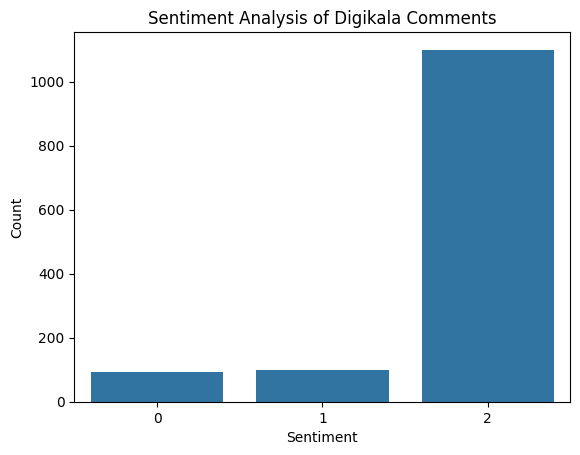

In [ ]:
data = {'comments': preprocessed_data['comment'], 'sentiment': preprocessed_data['label']}
df = pd.DataFrame(data)

sns.countplot(x='sentiment', data=df)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Digikala Comments')
plt.show()

fig = px.histogram(df, x='sentiment', title='Sentiment Analysis of Digikala Comments')
fig.show()